# Solving IK of a Robot Leg

 

<IPython.core.display.Javascript object>


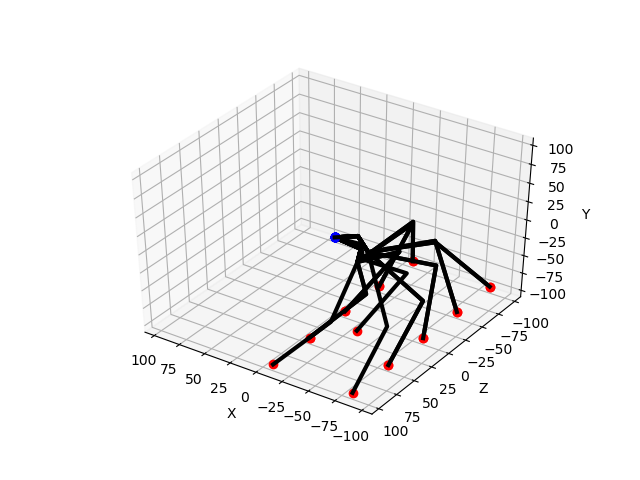

t1 5.641557408312655 t2 -44.214309032200575 t3 115.538242734043


In [598]:
%matplotlib notebook

from mpl_toolkits import mplot3d
import  numpy as np
import math
import matplotlib.pyplot as plt

ax = plt.axes(projection="3d")

ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_zlim(-200, 200)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")

# Lengths of Segments in mm

l1=25
l2=20
l3=80
l4=80

def plotall(x,y,z):

    """
    F=Length of shoulder-point to target-point on x/y only
    G=length we need to reach to the point on x/y
    H=3-Dimensional length we need to reach
    """

    F=math.sqrt(x**2+y**2-l1**2)
    G=F-l2  
    H=math.sqrt(G**2+z**2)

    theta1=-math.atan2(-y,x)-math.atan2(F,-l1)
    
    D=(H**2-l3**2-l4**2)/(2*l3*l4)
    theta3=math.acos(D) 
    
    theta2=math.atan2(z,G)-math.atan2(l4*math.sin(theta3),l3+l4*math.cos(theta3))
    
    """
    That's all! Now draw it
    """

    plt.plot([0],[0],[0],'bo',lw=2)
    plt.plot([x],[z],[-y],'ro',lw=2)
    
    l1x=-l1*math.cos(theta1)
    l1y=l1*math.sin(theta1)
    l1z=0

    l2x=l1x-l2*math.sin(theta1)
    l2y=l1y-l2*math.cos(theta1)
    l2z=0

    l3x=l2x-l3*math.sin(theta1)*math.cos(theta2)
    l3y=l2y-l3*math.cos(theta1)*math.cos(theta2)
    l3z=l2z+l3*math.sin(theta2)

    t4=theta2+theta3
    l4x=l3x-l4*math.sin(theta1)*math.cos(t4)
    l4y=l3y-l4*math.cos(theta1)*math.cos(t4)
    l4z=l3z+l4*math.sin(t4)

    plt.plot([0,l1x,l2x,l3x, l4x], [0,l1z,l2z,l3z, l4z],[0,l1y,l2y,l3y,l4y], 'k-', lw=3)

    print("t1 {} t2 {} t3 {}".format(theta1/(math.pi/180),theta2/(math.pi/180),theta3/(math.pi/180)))

x=-35
y=100
z=20

plotall(x,y,z)


In [600]:
for z in range(-100,150,50):
    plotall(x+25,y,z)
    plotall(x-50,y,z)


t1 -8.693512817483771 t2 -90.08596662278946 t3 75.60838782961788
t1 29.383456937777023 t2 -65.09048777087357 t3 45.029152007982034
t1 -8.693512817483771 t2 -87.74158867389455 t3 109.71790249431604
t1 29.383456937777023 t2 -66.20396734516805 t3 83.06118150453196
t1 -8.693512817483771 t2 -61.094097265125654 t3 122.18819453025132
t1 29.383456937777023 t2 -47.13633565192371 t3 94.27267130384742
t1 -8.693512817483771 t2 -21.97631382042148 t3 109.71790249431604
t1 29.383456937777023 t2 -16.857214159363902 t3 83.06118150453196
t1 -8.693512817483771 t2 14.47757879317158 t3 75.60838782961788
t1 29.383456937777023 t2 20.061335762891545 t3 45.029152007982034
